In [1]:
# !pip install torchinfo

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import joblib
import torch.nn as nn
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Specify the file name
file_name = "household_power_consumption.txt"  # Replace with your actual file name

# Read the data into a DataFrame
df = pd.read_csv(
    file_name,
    sep=';',  # Specify the delimiter
    parse_dates={'DateTime': ['Date', 'Time']},  # Combine 'Date' and 'Time' into 'DateTime'
    infer_datetime_format=True,  # Infer the datetime format for better performance
    low_memory=False  # Handle large files efficiently
)


<ipython-input-4-05f0fab8b720>:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-4-05f0fab8b720>:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
<ipython-input-4-05f0fab8b720>:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


In [5]:
df.shape

(2075259, 8)

In [6]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna()
df.shape

(2049280, 8)

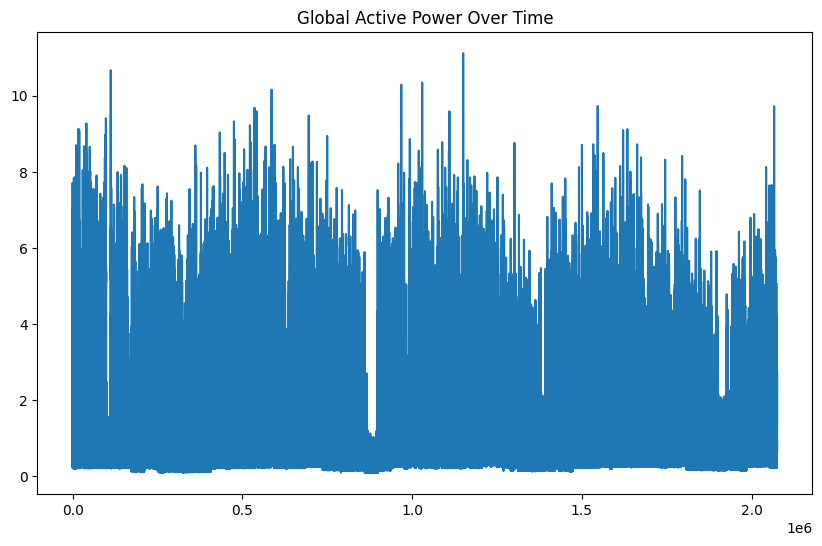

In [7]:
import matplotlib.pyplot as plt

df['Global_active_power'].plot(figsize=(10, 6), title="Global Active Power Over Time")
plt.show()


In [8]:
# Calculate time differences between consecutive rows
time_diffs = df.index.to_series().diff()

# Check the most common interval
print(time_diffs.value_counts().head())  # Most frequent time intervals


1.0       2049208
2.0            38
3.0            14
4.0             2
3724.0          1
Name: count, dtype: int64


In [9]:
df['DateTime'] = pd.to_datetime(df['DateTime'])  # Convert to datetime if not already
df.set_index('DateTime', inplace=True)

In [10]:
print(df.index)  # Check the values of the index
print(type(df.index))

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='DateTime', length=2049280, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [11]:
# Create a full range of 1-minute intervals
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='T')  # Continuous 1-min intervals
df = df.reindex(full_index)

<ipython-input-11-aa8659d8efc4>:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='T')  # Continuous 1-min intervals


In [12]:
# Interpolate missing values using time-based interpolation
df['Global_active_power'] = df['Global_active_power'].interpolate(method='time')


In [13]:
# Check the shape of the DataFrame
print(df.shape)  # The number of rows should now match the length of full_index

# Inspect the first and last few rows
print(df.head())

(2075259, 7)
                     Global_active_power Global_reactive_power  Voltage  \
2006-12-16 17:24:00                4.216                 0.418  234.840   
2006-12-16 17:25:00                5.360                 0.436  233.630   
2006-12-16 17:26:00                5.374                 0.498  233.290   
2006-12-16 17:27:00                5.388                 0.502  233.740   
2006-12-16 17:28:00                3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.000          1.000   

                     Sub_metering_3  
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2

In [14]:
df['DateTime'] = df.index
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Year'] = df['DateTime'].dt.year

# Normalize or encode periodic features
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min()))
df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min()))

In [15]:
df.shape

(2075259, 14)

In [16]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'DateTime', 'DayOfWeek', 'Year', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Year_sin', 'Year_cos'],
      dtype='object')

In [17]:
# Assuming `df` is your DataFrame
scaler = MinMaxScaler()

# Scale only the 'Global_active_power' column
df['Global_active_power_scaled'] = scaler.fit_transform(df[['Global_active_power']])

# Prepare the final DataFrame for LSTM
# Drop the original 'Global_active_power' if not needed
scaled_data = df[['Global_active_power_scaled', 'DayOfWeek_sin', 'DayOfWeek_cos',
                  'Year_sin', 'Year_cos']].to_numpy()

In [18]:
print(scaled_data.shape)
np.save("scaled_data.npy", scaled_data)
joblib.dump(scaler, "scaler.pkl")

(2075259, 5)


['scaler.pkl']

**`Training`**

In [3]:
scaler = joblib.load("scaler.pkl")
scaled_data = np.load("scaled_data.npy")
print("scaled_data loaded:")

scaled_data loaded:


In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):

        self.seq_length = seq_length
        self.data = data
        self.X, self.y = self.create_sequences(data, seq_length)

    def create_sequences(self, data, seq_length):

        X, y = [], []
        for i in tqdm(range(0, len(data) - seq_length), desc="Creating sequences"):
            X.append(data[i:i + seq_length, :])  # Input sequence
            y.append(data[i + seq_length, 0])  # Target values
        return np.array(X), np.array(y)

    def __len__(self):

        return len(self.X)

    def __getitem__(self, idx):

        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [5]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
seq_length =  480


In [6]:
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

# Create DataLoaders
batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Creating sequences: 100%|██████████| 414572/414572 [00:00<00:00, 1279370.45it/s]


In [7]:
for batch_X, batch_y in train_loader:
    print(f"Train Batch X shape: {batch_X.shape}")  # (batch_size, seq_length, num_features)
    print(f"Train Batch y shape: {batch_y.shape}")  # (batch_size, prediction_horizon)
    break

# Example: Iterate through the test DataLoader
for batch_X, batch_y in test_loader:
    print(f"Test Batch X shape: {batch_X.shape}")  # (batch_size, seq_length, num_features)
    print(f"Test Batch y shape: {batch_y.shape}")  # (batch_size, prediction_horizon)
    break

Train Batch X shape: torch.Size([2048, 480, 5])
Train Batch y shape: torch.Size([2048])
Test Batch X shape: torch.Size([2048, 480, 5])
Test Batch y shape: torch.Size([2048])


In [8]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, fcc_intermdeiate, prediction_horizon=1):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, fcc_intermdeiate)

        self.reul = nn.ReLU()

        self.fc2 = nn.Linear(fcc_intermdeiate, prediction_horizon)

    def forward(self, x):
        out, _ = self.lstm(x)

        out = self.fc1(out[:, -1, :])

        out = self.reul(out)

        out = self.fc2(out)

        return out.squeeze()


In [9]:
input_size = 5  # Number of features
hidden_size = 64
num_layers = 2
model = Model(input_size, hidden_size, num_layers, fcc_intermdeiate=8).to(device)

# Generate summary
summary(model, input_data=batch_X.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [2048]                    --
├─LSTM: 1-1                              [2048, 480, 64]           51,456
├─Linear: 1-2                            [2048, 8]                 520
├─ReLU: 1-3                              [2048, 8]                 --
├─Linear: 1-4                            [2048, 1]                 9
Total params: 51,985
Trainable params: 51,985
Non-trainable params: 0
Total mult-adds (G): 50.58
Input size (MB): 19.66
Forward/backward pass size (MB): 503.46
Params size (MB): 0.21
Estimated Total Size (MB): 523.33

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    train_loss = 0.0
    for batch_X, batch_y in tqdm(train_loader, desc="Training"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)


def val_epoch(model, val_loader, criterion, device):

    model.eval()
    val_loss = 0.0
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for batch_X, batch_y in tqdm(val_loader, desc="Validation"):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item()

            test_predictions.append(outputs.cpu().numpy())
            test_targets.append(batch_y.cpu().numpy())

    test_predictions = np.concatenate(test_predictions, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)

    return val_loss / len(val_loader), test_predictions, test_targets



In [11]:
learning_rate = 0.0001
num_epochs = 10

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Training and Validation
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train for one epoch
    avg_train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(avg_train_loss)

    # Validate for one epoch
    avg_val_loss, test_predictions, test_targets = val_epoch(model, test_loader, criterion, device)
    val_losses.append(avg_val_loss)

    # Log epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Validation: 100%|██████████| 203/203 [00:12<00:00, 15.74it/s]


Epoch [1/10], Train Loss: 0.0052, Val Loss: 0.0014


Validation: 100%|██████████| 203/203 [00:13<00:00, 15.59it/s]


Epoch [2/10], Train Loss: 0.0013, Val Loss: 0.0007


Validation: 100%|██████████| 203/203 [00:12<00:00, 15.73it/s]


Epoch [3/10], Train Loss: 0.0009, Val Loss: 0.0005


Validation: 100%|██████████| 203/203 [00:12<00:00, 15.77it/s]


Epoch [4/10], Train Loss: 0.0007, Val Loss: 0.0004


Validation: 100%|██████████| 203/203 [00:12<00:00, 15.79it/s]


Epoch [5/10], Train Loss: 0.0006, Val Loss: 0.0004


Validation: 100%|██████████| 203/203 [00:12<00:00, 15.73it/s]


Epoch [6/10], Train Loss: 0.0006, Val Loss: 0.0004


Training:   6%|▌         | 47/811 [00:09<02:32,  5.00it/s]


KeyboardInterrupt: 

In [12]:
# Example: Rescaling predictions and targets
def evaluate_predictions(scaler, predictions, targets):
    """
    Evaluate the accuracy of predictions by rescaling and computing metrics.

    Args:
        scaler (MinMaxScaler): Scaler used to normalize the target variable.
        predictions (numpy array): Predicted values (scaled).
        targets (numpy array): Ground truth values (scaled).

    Returns:
        dict: Dictionary containing RMSE, MAE, and MAPE metrics.
    """
    # Rescale predictions and targets
    predictions_rescaled = scaler.inverse_transform(predictions)
    targets_rescaled = scaler.inverse_transform(targets)

    # Compute evaluation metrics
    mae = mean_absolute_error(targets_rescaled, predictions_rescaled)
    rmse = np.sqrt(mean_squared_error(targets_rescaled, predictions_rescaled))
    mape = np.mean(np.abs((targets_rescaled - predictions_rescaled) / targets_rescaled)) * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

# Assuming `test_predictions` and `test_targets` are numpy arrays (scaled values)
# Reshape if necessary for inverse_transform
test_predictions = test_predictions.reshape(-1, 1)
test_targets = test_targets.reshape(-1, 1)

metrics = evaluate_predictions(scaler, test_predictions, test_targets)

print(f"Mean Absolute Error (MAE): {metrics['MAE']:.4f}")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%")


Mean Absolute Error (MAE): 0.0941
Root Mean Squared Error (RMSE): 0.2196
Mean Absolute Percentage Error (MAPE): 12.10%


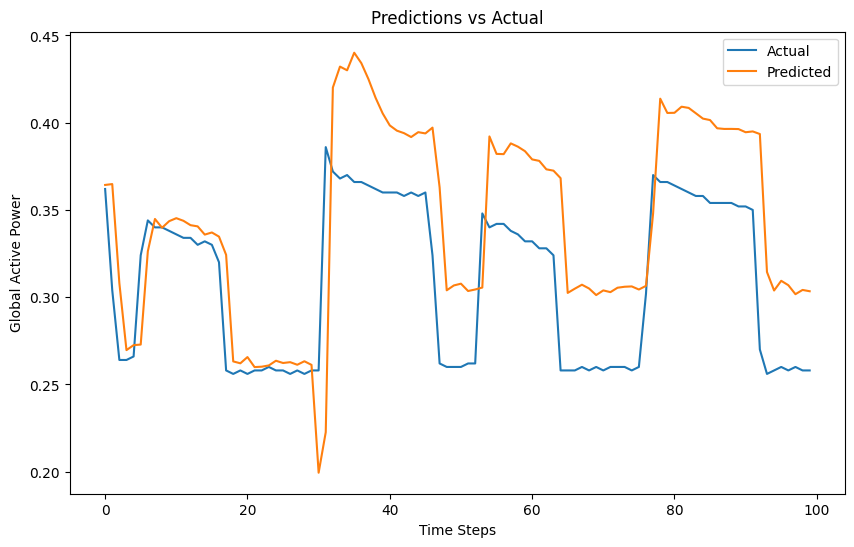

In [13]:
# Rescale for visualization
predictions_rescaled = scaler.inverse_transform(test_predictions)
targets_rescaled = scaler.inverse_transform(test_targets)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(targets_rescaled[:100], label='Actual')
plt.plot(predictions_rescaled[:100], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()